# Eigenes Modell zur Segmentierung von Unterwasserbilder

Es soll ein Modell auf dem SUIM-Datensatz trainiert werden, welches die Pixel klassifiziert als:
- Background (waterbody) BW (black)
- Human divers HD (blue)
- Aquatic plants and sea-grass PF (green)
- Wrecks and ruins WR (sky)
- Robots (AUVs/ROVs/instruments) RO (red)
- Reefs and invertebrates RI (pink)
- Fish and vertebrates FV (yellow)
- Sea-floor and rocks SR (white)

(links zum Paper, Datenset, Code aus Paper befindet sich im README.md)

Ausserdem wird das SUIM-Net (siehe Notebook `suim_net.ipynb`) aus dem Paper mit Pytorch implementiert und mit diesem Modell verglichen.

In [1]:
# import: external libraries
import torch
import torchshow as ts
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torch import nn
from PIL import Image

print(f"cuda: {torch.cuda.is_available()}")

# import: solutions from the lessons
from underwater_imagery.models.my_net.my_net import MyModel
from underwater_imagery.models.my_net.my_encoder import Encoder
from underwater_imagery.models.my_net.my_decoder import Decoder

# import: own modules
from underwater_imagery.models.iou_loss import SoftIoULoss
from underwater_imagery.data.uim_dataset import UIMDataset
from underwater_imagery.data.constants import TEST_PATH, TRAIN_PATH, CLASSES, SHAPE
from underwater_imagery.data.transf import resize_transf, resize_normalize_transf
from underwater_imagery.models.iou_loss import SoftIoULoss
from underwater_imagery.models.metrics import logits_to_idx_class, eval
from underwater_imagery.data.transf import pred_to_label
from underwater_imagery.models.train_model import train_model

cuda: True


In [2]:
batch_size = 8

Hier werden sämtliche Bildauflösungen ausgegeben. Da die Modelle mit fixen Dimensionen arbeiten, werden diese resized. Kann in der `SHAPE` variabel in `constants.py` konfiguriert werden. RGB Werte des Images werden zusätzlich normalisiert.

In [3]:
sizes = []
for img_path in TRAIN_PATH.glob("./images/*.jpg"):
    img = Image.open(str(img_path.absolute()))
    arr = np.array(img)
    w, h, _ = arr.shape
    sizes.append([w, h])
print(np.unique(sizes, axis=0))

[[ 360  640]
 [ 375  590]
 [ 416  416]
 [ 435  910]
 [ 448  480]
 [ 480  584]
 [ 480  640]
 [ 540  960]
 [ 600  800]
 [ 720 1152]
 [ 720 1280]
 [ 960 1280]
 [1080 1906]]


In der folgenden Zelle ist ein Beispielbild aus dem Trainingsset, welches aus 1525 Bildern besteht. Dies ist eher klein und es sollte auf overfitting geachtet werden. Das Testset besteht aus 110 Bildern. Auffallend ist, dass Background (BW) und Wrecks and Ruins (WR) den grossteil der Pixel ausmacht. WR sind ausserdem meist in der unteren Hälfte des Bildes (da diese am Grund liegen). Somit sollte ein Modell, welches in der oberen Hälfte BW vorhersagt und in der unteren Hälfte RW vorhersagt schon im Recall Punkten. Jedoch würde dies das Ziel verfehlen.

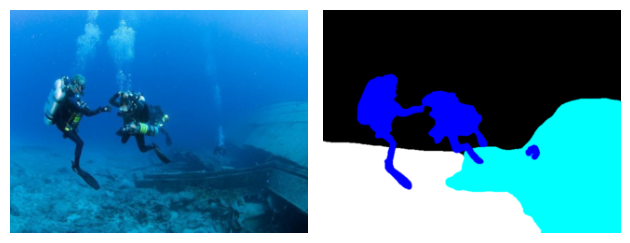

BW


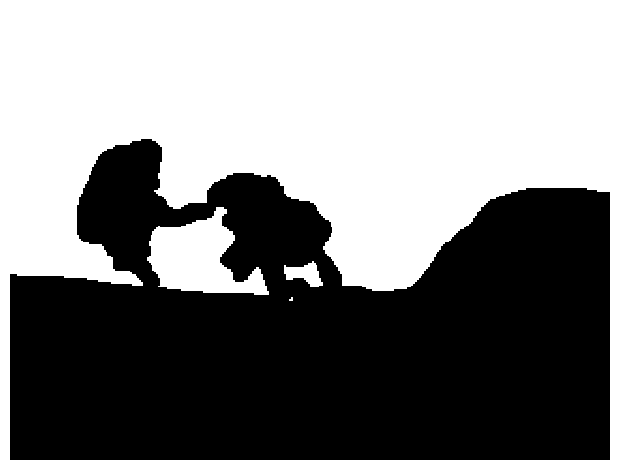

HD


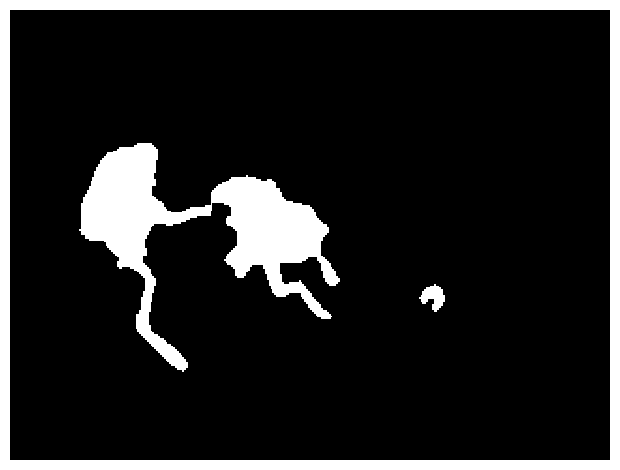

PF


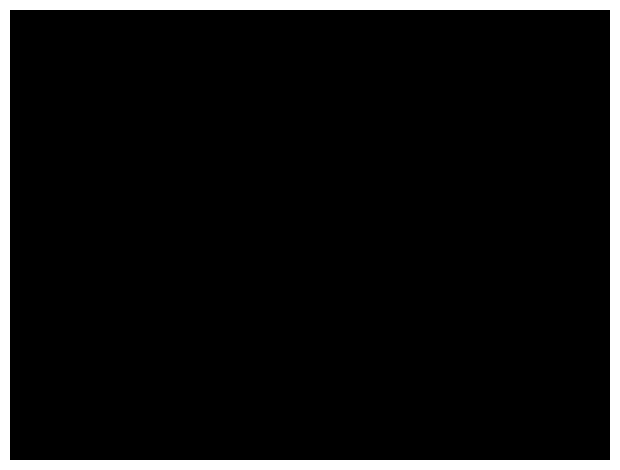

WR


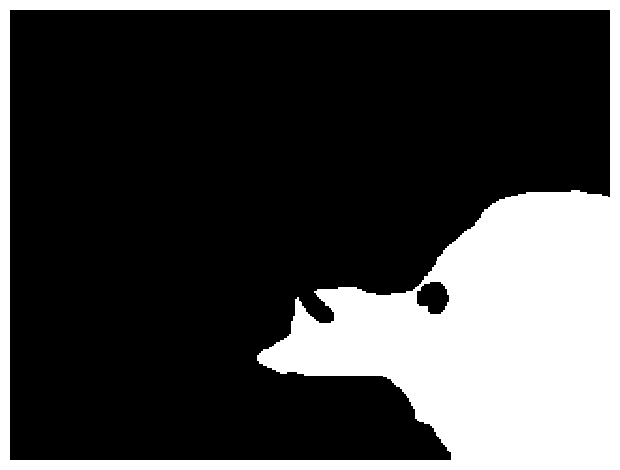

RO


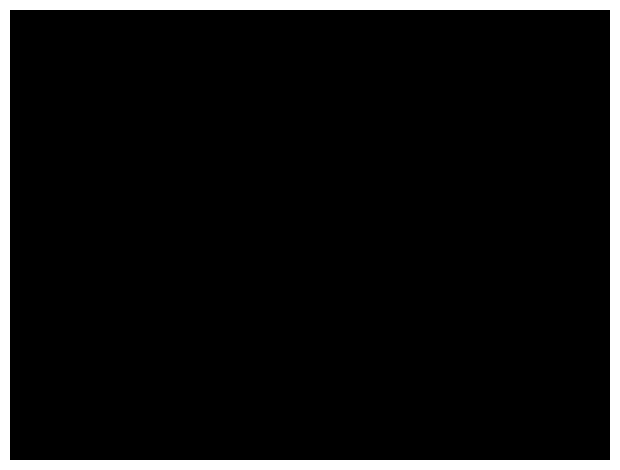

RI


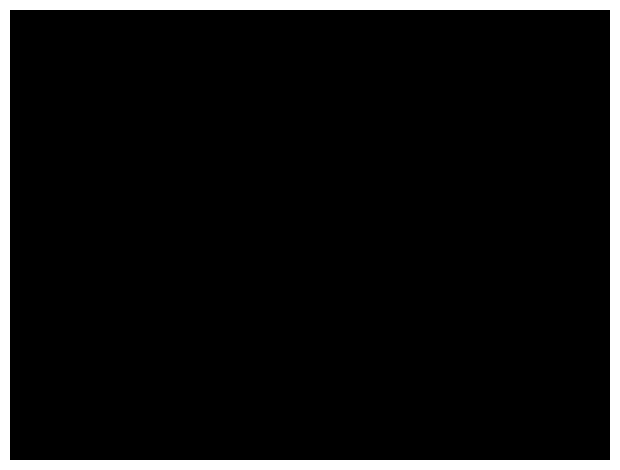

FV


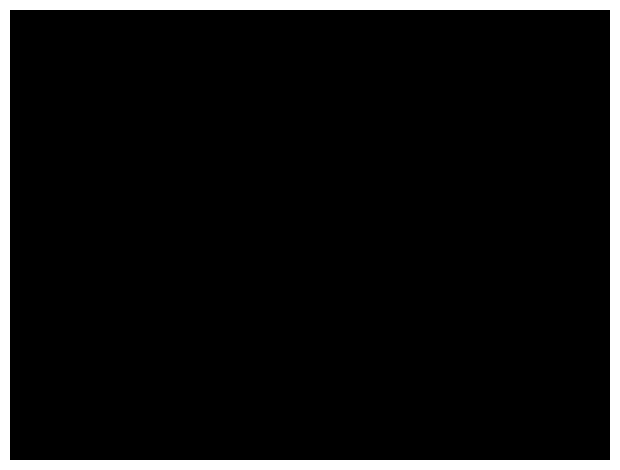

SR


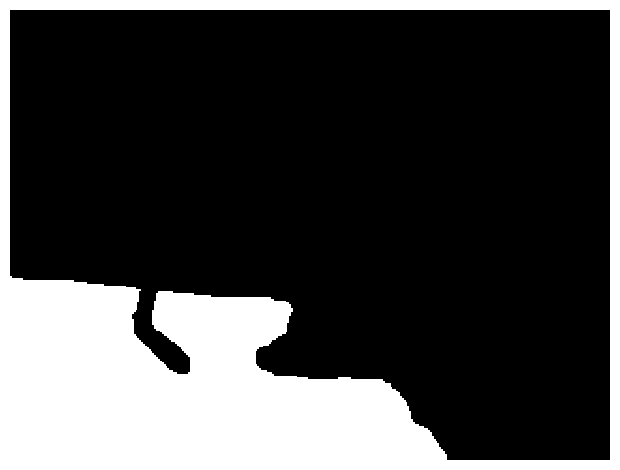

In [4]:
data = UIMDataset(
    TRAIN_PATH, 
    CLASSES, 
    SHAPE,
    resize_transf, 
    resize_transf
)

img, mask, label = data[0]
ts.show([img, label])
plt.show()

for i, cls in enumerate(data.classes):
    print(cls[0])
    ts.show(mask[i, :, :]) 
    plt.show()

In [5]:
# Überprüfen der Architektur. Pro Klasse eine Maske und Input dim == Output dim.
num_channels = [16, 32, 64]
num_classes = len(data.classes)

encoder = Encoder(num_channels)
decoder = Decoder(list(reversed(num_channels)))
encoder_decoder = MyModel(
    encoder, 
    decoder, 
    num_initial_channels=16,
    num_input_channels=16,
    num_output_channels=num_classes
)

pred = encoder_decoder(img.to('cuda'))
assert num_classes == pred.shape[0]
assert img.shape[1] == pred.shape[1]
assert img.shape[2] == pred.shape[2]

In [6]:
ds = UIMDataset(
    TRAIN_PATH, 
    CLASSES, 
    SHAPE,
    resize_normalize_transf,
    resize_transf
)

ds_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

# Training des Model

Die Architektur des Models ist aus dem Unterrichtsmaterial inspiriert (übung07).
Das Ziel des Trainings hier ist den IoU loss zu minimieren. Da dieser jedoch nicht differenzierbar ist, wurde die softmax Variante implementiert. Zusätzlich wird der Log. siehe(`iou_loss.py`). 
Hyperparameter-Tuning mit Crossvalidation auf Teilset des Trainingsset wurde aufgrund von Rechenaufwand/Zeit verzichtet.

In [7]:
# train the model
torch.manual_seed(123)

# Parameters
num_epochs = 40

# create model
num_channels = [64, 128, 256]
num_classes = len(ds.classes)
encoder = Encoder(num_channels)
decoder = Decoder(list(reversed(num_channels)))
my_model = MyModel(
    encoder, 
    decoder, 
    num_initial_channels=num_channels[0], 
    num_input_channels=num_channels[0], 
    num_output_channels=num_classes,
    device="cuda"
)

# Create Loss-Function
criterion = nn.CrossEntropyLoss()
iou_loss = SoftIoULoss()

_ = train_model(
    model=my_model,
    loss_module=criterion,
    ds_loader=ds_loader,
    num_epochs=num_epochs,
    file_name=f"my_model_epoch{num_epochs}"
)

  0%|          | 0/7640 [00:00<?, ?it/s]

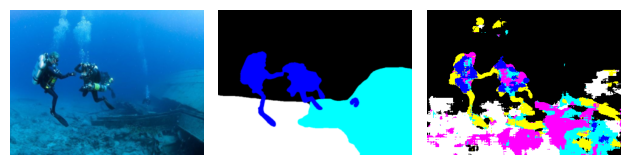

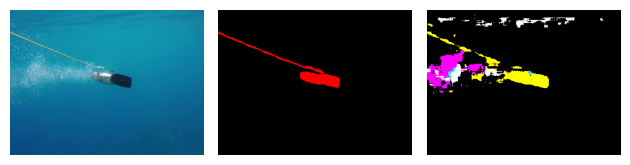

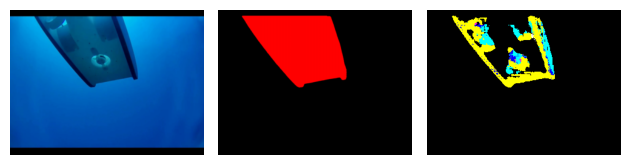

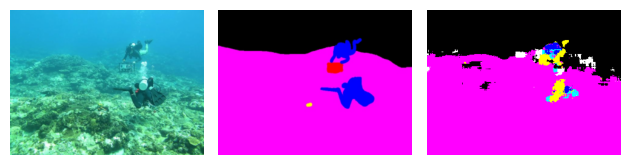

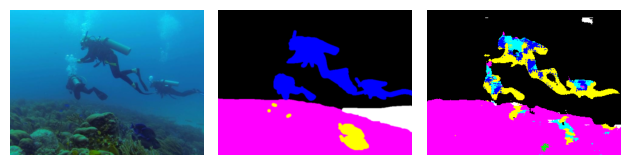

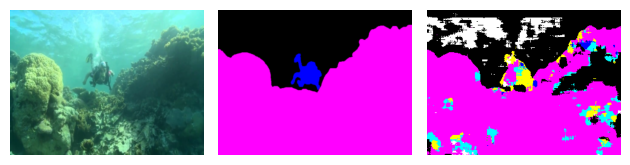

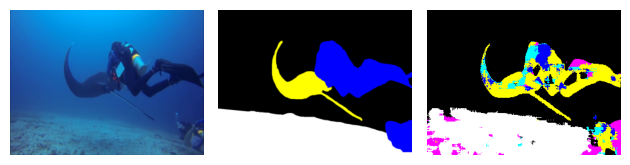

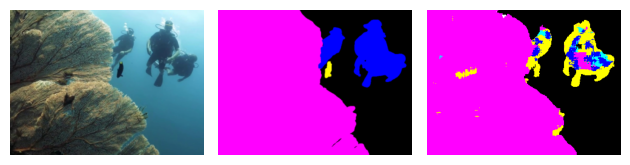

In [13]:
for i in range(0, 15, 2):
    images, _, label_images = ds[i]
    images = images.unsqueeze(0).to(encoder_decoder.device)
    logits = my_model(images)
    pred = logits_to_idx_class(logits)
    pred_label = pred_to_label(pred).squeeze(0)
    ts.show([images.squeeze(0), label_images, pred_label])

In [9]:
ds_test = UIMDataset(
    TEST_PATH, 
    CLASSES, 
    SHAPE,
    resize_normalize_transf,
    resize_transf
)

ds_test_loader = DataLoader(
    ds_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

train eval
always micro
precision: 0.685
recall: 0.685
f1 score: 0.685
mean pixel acc: 0.685
soft log IoU loss: 1.885
cross entropy loss: 0.576


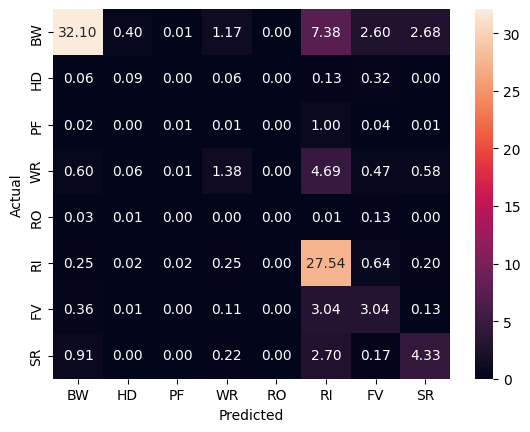

In [10]:
print("train eval")
eval(
    my_model,
    ds_loader,
    device=my_model.device
)

test eval
always micro
precision: 0.654
recall: 0.654
f1 score: 0.654
mean pixel acc: 0.654
soft log IoU loss: 1.903
cross entropy loss: 0.845


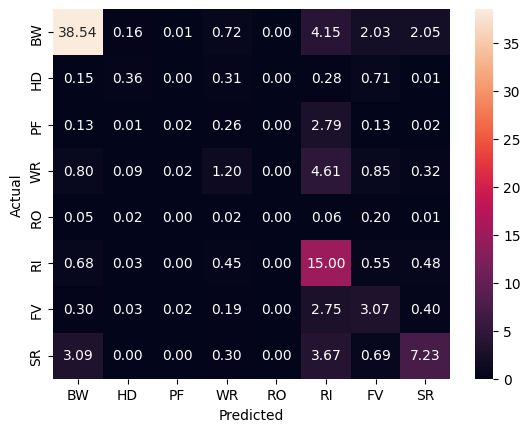

In [11]:
print("test eval")
eval(
    my_model,
    ds_test_loader,
    device=my_model.device,
    max_iter=110
)

Auch bei diesem Modell wird häufig fälschlichweise RI vorhergesagt. Der Train- und Testscore sind ähnlich. Es fand kein overfitting statt.

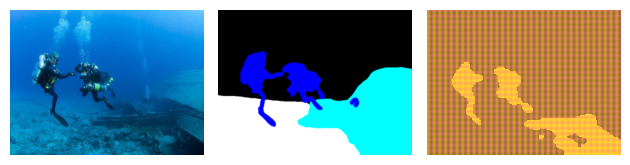

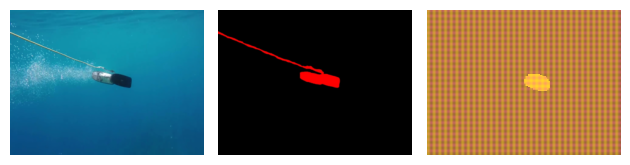

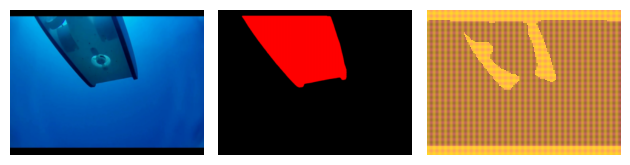

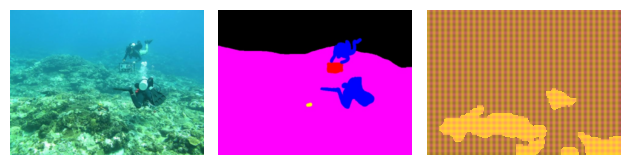

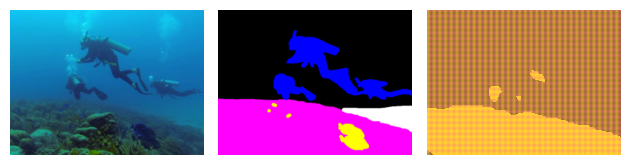

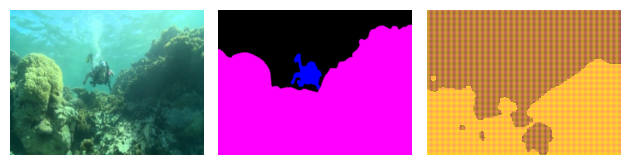

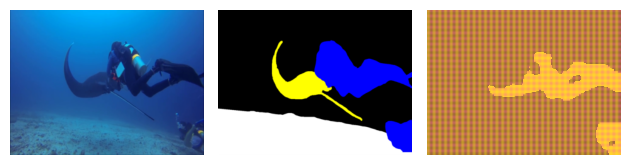

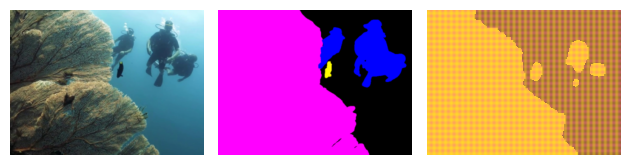

In [14]:
my_model = torch.load("my_model_epoch100_iou.pth")
my_model.eval()
for i in range(0, 15, 2):
    images, _, label_images = ds[i]
    images = images.unsqueeze(0).to(encoder_decoder.device)
    logits = my_model(images)
    pred = logits_to_idx_class(logits)
    pred_label = pred_to_label(pred).squeeze(0)
    ts.show([images.squeeze(0), label_images, pred_label])

Interessant ist hier der Moiré-Effekt. Die Cross Entropy schneidet besser ab.